## Importing libraries we'll need

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
from sklearn import model_selection #this will be used to randomise the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def sigmoid(h_value):
    '''Takes a value normalises it to be between 0 and 1, will be useful later'''
    return float(1)/(1+math.e**-h_value)

## Loading the file

In [2]:
df = pd.read_csv(r'P:\ENGINEERING\FPO\Digitalisation\1 FPO Projects\IIX Data Analytics\02-General presentations\Knowledge folder - preparation\Data Science Learning Framework\Machine Learning Posters\3 - Logistic Regression\t_off_land.csv')
df.head() #checking what our data looks like

,flight_segment,total_fuel_weight,flap_pos
0,TAKE_OFF,8708.964844,13.974609
1,TAKE_OFF,8745.251953,13.974609
2,TAKE_OFF,8799.683594,13.974609
3,TAKE_OFF,8926.689453,13.974609
4,LAND,4154.901855,24.960938


# Plotting the data to investigate

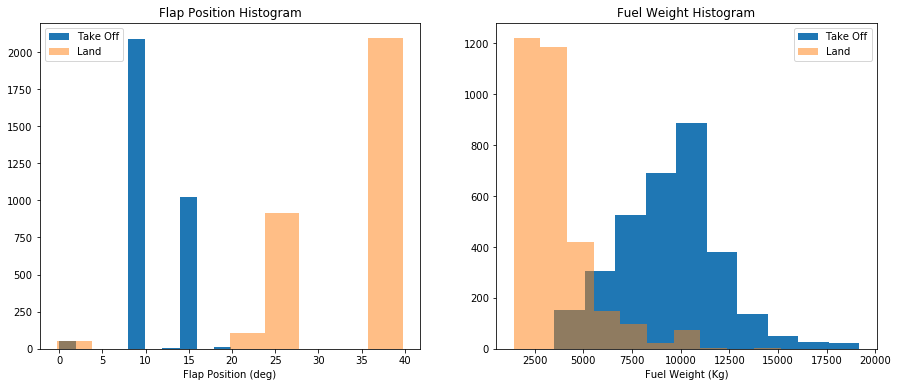

In [3]:
f = plt.figure(figsize=(15,6))
#plotting histogram of flap position, separated by take off and land
ax = f.add_subplot(121)
ax = plt.hist(df[df["flight_segment"] == "TAKE_OFF"]["flap_pos"])
ax = plt.hist(df[df["flight_segment"] == "LAND"]["flap_pos"], alpha = 0.5)
plt.xlabel("Flap Position (deg)")
plt.title("Flap Position Histogram")
plt.legend(["Take Off", "Land"])

#plotting histogram of fuel weight, separated by take off and land
ax2 = f.add_subplot(122)
ax2 = plt.hist(df[df["flight_segment"] == "TAKE_OFF"]["total_fuel_weight"])
ax2 = plt.hist(df[df["flight_segment"] == "LAND"]["total_fuel_weight"], alpha = 0.5)
plt.xlabel("Fuel Weight (Kg)")
plt.title("Fuel Weight Histogram")
plt.legend(["Take Off", "Land"])

## Formatting the data

In [4]:
def binary(entry):
    '''Converting classification to numeric format, such that the model can target it (take off = 0, land = 1)'''
    if entry == "TAKE_OFF":
        return 0
    else:
        return 1
    
df["flight_segment"] = df["flight_segment"].apply(binary) #applying function to column
df["constant"] = 1 #adding a column to calculate theta_0
df.head()

,flight_segment,total_fuel_weight,flap_pos,constant
0,0,8708.964844,13.974609,1
1,0,8745.251953,13.974609,1
2,0,8799.683594,13.974609,1
3,0,8926.689453,13.974609,1
4,1,4154.901855,24.960938,1


In [5]:
#separating data into features (what we're using to classify), and labels (what we're trying to predict)
X = df[["constant","flap_pos","total_fuel_weight"]].copy() #features
y = df["flight_segment"].copy() #labels

#train_test_split randomly splits the data to avoid bias, here we've used 70% of the data to train and 30% to test the model
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=101)

In [6]:
#scaling our data, if flap position and fuel weight are of similar magnitude, the model will converge faster
for col in X_train.columns[1:]:
    X_train.loc[:,col] = (X_train.loc[:,col]-np.mean(X_train.loc[:,col]))/(np.max(X_train.loc[:,col])-np.min(X_train.loc[:,col]))
    X_test.loc[:,col] = (X_test.loc[:,col]-np.mean(X_test.loc[:,col]))/(np.max(X_test.loc[:,col])-np.min(X_test.loc[:,col]))

X_train, y_train = np.array(X_train), np.array(y_train) #converting to matrices instead of dataframes for functionality

## Performing gradient descent

In [7]:
grad_desc_iterations = 300 #setting number of iterations
alpha = 10 #setting the learning rate
J = np.zeros((grad_desc_iterations,1)) #creating empty matrix to fill with cost at each iteration
thetas = np.zeros((grad_desc_iterations+1,len(X.columns))) #creating empty matrix of thetas at each iteration, the last row will be best fit for model

for i in range(grad_desc_iterations): #for each gradient descent iteration...
    #assigning a cost value for each iteration, the operations are explained at the end of document
    J[i] = -(float(1)/len(X_train))*np.sum(y_train*np.log(sigmoid(np.sum(thetas[i]*X_train,axis = 1)))+(1-y_train)*np.log(1-sigmoid(np.sum(thetas[i]*X_train,axis = 1))))
    #updating theta with gradient descent for the next iteration, operations are explained at the end of the document
    thetas[i+1] = thetas[i] - (alpha/len(X))*np.dot(sigmoid(np.sum(thetas[i]*X_train,axis = 1))-y_train,X_train)

## Plotting the cost

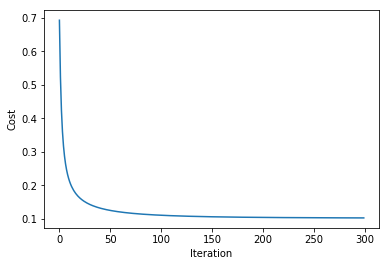

In [8]:
plt.plot(range(grad_desc_iterations), J) #plotting iterations vs. cost (J)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Predicting fuel burn for the test data

In [9]:
#multiplying thetas by test values, then rounding the value to 1 or 0 to give our prediction of y!
X_test["predic"] = np.round(sigmoid(np.sum(thetas[-1]*X_test,axis = 1)))
X_test["flight_segment"] = y_test #adding the actual y value for testing our success later

## Plotting results

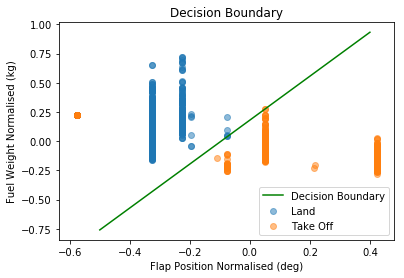

In [10]:
#rearranging the hypothesis equation set equal to 0, this gives us our decision bounday (if hypothesis < 0 prediction is 0, otherwise 1)
x = []
y = []
for i in np.arange(-0.5,0.5,0.1):
    #assigning decision boundary coordinates for the normalised features' range
    x.append(i)
    y.append((-thetas[-1][0]-thetas[-1][1]*i)/thetas[-1][2])

#separating test data into take_off/land and plotting
plt.scatter(X_test[X_test["flight_segment"] == 0]["flap_pos"], X_test[X_test["flight_segment"] == 0]["total_fuel_weight"],alpha = 0.5)
plt.scatter(X_test[X_test["flight_segment"] == 1]["flap_pos"], X_test[X_test["flight_segment"] == 1]["total_fuel_weight"],alpha = 0.5)
plt.plot(x,y,color = 'g') #plotting decision boundary
plt.xlabel("Flap Position Normalised (deg)")
plt.ylabel("Fuel Weight Normalised (kg)")
plt.legend(["Decision Boundary", "Land", "Take Off"])
plt.title("Decision Boundary")
plt.savefig("decision boundary.png")

## Analysing model

In [11]:
#printing the % of rows that were correctly assigned in the test data...
correct = len(X_test[(X_test["predic"] == 0.0) & (X_test["flight_segment"] == 0.0)]) + len(X_test[(X_test["predic"] == 1.0) & (X_test["flight_segment"] == 1.0)])
fraction = float(correct)/len(X_test)
print("{}% correctly assigned".format(np.round(fraction*100,2)))

99.21% correctly assigned


In [12]:
#making a confusion matrix
np.array([[len(X_test[(X_test["predic"] == 0.0) & (X_test["flight_segment"] == 0.0)]),\
           len(X_test[(X_test["predic"] == 1.0) & (X_test["flight_segment"] == 0.0)])],\
          [len(X_test[(X_test["predic"] == 0.0) & (X_test["flight_segment"] == 1.0)]),\
           len(X_test[(X_test["predic"] == 1.0) & (X_test["flight_segment"] == 1.0)])]])

#confusion matrices show how many false negatives (predicted negative when actually positive), 
#                                 true negatives (predicted negative and is negative)
#                                 false positives (predicted positive when actually negative) and
#                                 true positives (predicted positive and is positive)
# are present in your test data, they are 2x2 matrices of the form:
#{[true negative, false positive]
# [false negative, true positive]}

array([[922,   0],
       [ 15, 967]])